# Install Environment

In [ ]:
!pip install transformers[torch]
!pip install datasets
import os
import pandas as pd
import torch
import transformers as tr
from datasets import Dataset, load_metric
import numpy as np
from transformers import Trainer
from sklearn.metrics import classification_report, accuracy_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00


## Data Importing

### Clean Data

In [ ]:
# df_test.dropna(subset=['text'], inplace=True)  # drop rows where 'text' is null

In [ ]:
# GonzaloA data
clean_1_train = pd.read_csv("https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/train%20Data.csv")     # 24352 row
clean_1_train = clean_1_train[['text', 'label']]
# clean_1_train['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


clean_1_test = pd.read_csv("https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/test%20Data.csv")       # 16240 row
clean_1_test = clean_1_test[['text', 'label']]
# clean_1_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


# pushpdeepfake_news_combined
clean_2_train = pd.read_csv("https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/train.csv")   # 34916 row
clean_2_train = clean_2_train[['text', 'label']]
# clean_2_train['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


clean_2_test = pd.read_csv("https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/test.csv")     # 10003 row
# clean_2_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)

### Trash Data

In [ ]:
# kaggle_datafake
trash_1 = pd.read_csv("https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/kaggle_datafake.csv")       # 232003 row
trash_1 = trash_1[['text', 'label']]

# news_articles
trash_2 = pd.read_csv("https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/news_articles.csv")         # 2100 row
trash_2 = trash_2[['text', 'label']]
trash_2['label'] = trash_2['label'].str.lower()

# Fine tune on clean data

# New Section

## Fine Tuning

In [ ]:
dataset = Dataset.from_pandas(clean_1_train)
dataset = dataset.train_test_split(test_size=0.2)
dataset["train"]["label"]

In [ ]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(x["text"], text_target=target_labels,
                              return_tensors="pt", truncation=True, padding=True,)
        return token_res
    return apply

In [ ]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

In [ ]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(to_tokens, batched=True, remove_columns=["text", "label"])

Map:   0%|          | 0/19482 [00:00<?, ? examples/s]

Map:   0%|          | 0/4871 [00:00<?, ? examples/s]

In [ ]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [ ]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [tokenizer.decode(p, skip_special_tokens=True) for p in predictions.argmax(dim=-1)]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

<ipython-input-10-7f0b2327ce8d>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss
500,0.521800
1000,0.022900


TrainOutput(global_step=1218, training_loss=0.22736217509741072, metrics={'train_runtime': 660.6632, 'train_samples_per_second': 29.489, 'train_steps_per_second': 1.844, 'total_flos': 2636728976277504.0, 'train_loss': 0.22736217509741072, 'epoch': 1.0})

In [ ]:
# trainer.evaluate()

In [ ]:
trainer.save_model()

In [ ]:
trainer.save_state()

In [ ]:
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"


In [ ]:
trainer.save_model(output_dir=final_model_path)


In [ ]:
fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)


## Evaluate on Datasets

### Take 100 samples from each dataset

In [ ]:
clean_1_test = clean_1_test.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
clean_1_test = clean_1_test.sample(frac=1, random_state=42)
clean_1_test.dropna(subset=['text'], inplace=True)
clean_1_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


clean_2_train = clean_2_train.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
clean_2_train = clean_2_train.sample(frac=1, random_state=42)
clean_2_train.dropna(subset=['text'], inplace=True)
clean_2_train['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


clean_2_test = clean_2_test.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
clean_2_test = clean_2_test.sample(frac=1, random_state=42)
clean_2_test.dropna(subset=['text'], inplace=True)
clean_2_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


trash_1 = trash_1.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
trash_1 = trash_1.sample(frac=1, random_state=42)
trash_1.dropna(subset=['text'], inplace=True)


trash_2 = trash_2.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
trash_2 = trash_2.sample(frac=1, random_state=42)
trash_2.dropna(subset=['text'], inplace=True)

In [ ]:
def evaluate_data(df):
    # Initialize an empty list to store the predictions
    predictions = []

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        text = row["text"]
        news_report = [text]  # Create a list with the text from the DataFrame

        # Tokenize and generate predictions
        inputs = tokenizer(news_report, return_tensors="pt", truncation=True, padding=True)
        pred = fine_tuned_model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

        # Decode the predictions and store them in the predictions list
        classification = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(classification)

    # Add the predictions to the DataFrame as a new column
    df["predictions"] = predictions



    classification_rep = classification_report(df['label'], df['predictions'])
    print("Classification Report:")
    print(classification_rep)

    accuracy = accuracy_score(df['label'], df['predictions'])

    return accuracy


In [ ]:
clean_1_test_acc = evaluate_data(clean_1_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.98      0.99        50
        real       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
clean_2_train_acc = evaluate_data(clean_2_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      1.00      0.99        50
        real       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
clean_2_test_acc = evaluate_data(clean_2_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.98      0.99        50
        real       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
trash_1_acc = evaluate_data(trash_1)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.50      0.84      0.63        50
        real       0.50      0.16      0.24        50

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.43       100
weighted avg       0.50      0.50      0.43       100



In [ ]:
trash_2_acc = evaluate_data(trash_2)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.62      0.62        50
        real       0.60      0.60      0.60        48

    accuracy                           0.61        98
   macro avg       0.61      0.61      0.61        98
weighted avg       0.61      0.61      0.61        98



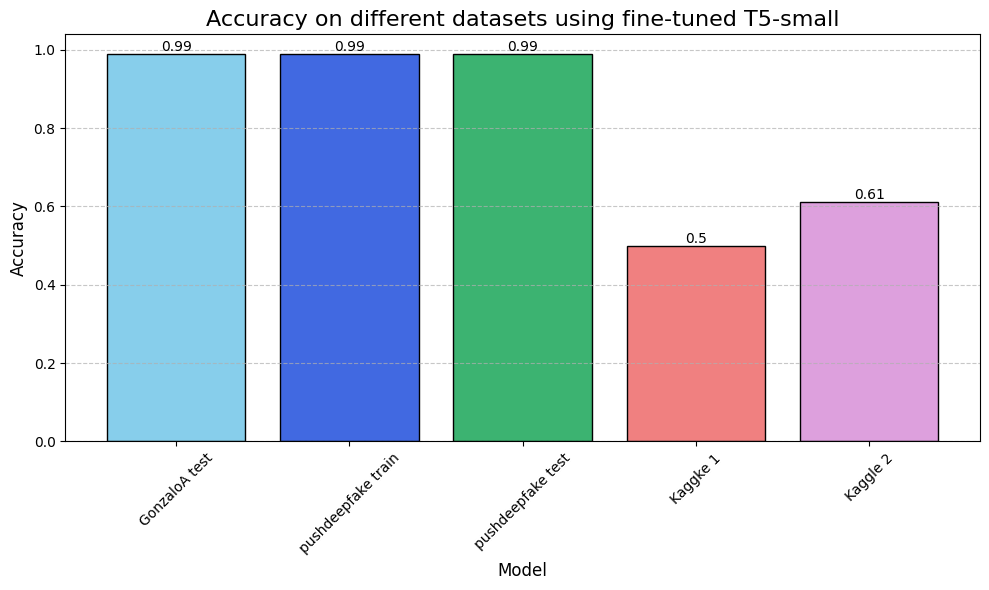

In [ ]:
import matplotlib.pyplot as plt

# Model labels
models = ["GonzaloA test","pushdeepfake train","pushdeepfake test","Kaggke 1","Kaggle 2"]

# Accuracy values
accuracies = [clean_1_test_acc, clean_2_train_acc, clean_2_test_acc, trash_1_acc, trash_2_acc]

# Create a color list to distinguish between 'summ' and non-summ models
colors = ['skyblue', 'royalblue', 'mediumseagreen', 'lightcoral', 'plum']

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor='black')

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom', ha='center')

plt.title('Accuracy on different datasets using fine-tuned T5-small', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Fine tune on mixed data

## Prepare data

In [ ]:
trash_1_train = trash_1.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 12000)))
trash_1_test = trash_1.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
trash_1_train = trash_1_train.sample(frac=1, random_state=42)
trash_1_train.dropna(subset=['text'], inplace=True)
trash_1_train['label'].replace({'fake' : 0, 'real' : 1}, inplace=True)

In [ ]:
mixed_df = pd.concat([clean_1_train, trash_1_train])
mixed_df

,text,label
0,Maury is perhaps one of the trashiest shows on...,0
1,"Yesterday, after the father of one of the UCLA...",0
2,MOSCOW (Reuters) - Russia on Wednesday warned ...,1
3,"House Majority Whip Steve Scalise (R., La.) th...",0
4,It can be said that Late Show host Stephen Col...,0
...,...,...
153345,Purecircle Ltd : * Margins are expected to hav...,1
86764,Local officials have tried a variety of things...,0
130925,"Warner Bros., Disney and Fox studios had been ...",0
186320,"FRANKFURT, Sept 7 (Reuters) - European Central...",1


## Fine-tune the model

In [ ]:
dataset = Dataset.from_pandas(mixed_df)
dataset = dataset.train_test_split(test_size=0.2)
dataset["train"]["label"]

In [ ]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(x["text"], text_target=target_labels,
                              return_tensors="pt", truncation=True, padding=True,)
        return token_res
    return apply

In [ ]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

In [ ]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(to_tokens, batched=True, remove_columns=["text", "label"])

Map:   0%|          | 0/38682 [00:00<?, ? examples/s]

Map:   0%|          | 0/9671 [00:00<?, ? examples/s]

In [ ]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [ ]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [tokenizer.decode(p, skip_special_tokens=True) for p in predictions.argmax(dim=-1)]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss
500,0.786400
1000,0.109200
1500,0.075800
2000,0.071200


TrainOutput(global_step=2418, training_loss=0.22699982632872878, metrics={'train_runtime': 1192.341, 'train_samples_per_second': 32.442, 'train_steps_per_second': 2.028, 'total_flos': 5235291564539904.0, 'train_loss': 0.22699982632872878, 'epoch': 1.0})

In [ ]:
# trainer.evaluate()

In [ ]:
trainer.save_model()

In [ ]:
trainer.save_state()

In [ ]:
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"


In [ ]:
trainer.save_model(output_dir=final_model_path)


In [ ]:
fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)


## Evaluate on Datasets

In [ ]:
clean_1_test = clean_1_test.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
clean_1_test = clean_1_test.sample(frac=1, random_state=42)
clean_1_test.dropna(subset=['text'], inplace=True)
clean_1_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


clean_2_train = clean_2_train.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
clean_2_train = clean_2_train.sample(frac=1, random_state=42)
clean_2_train.dropna(subset=['text'], inplace=True)
clean_2_train['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


clean_2_test = clean_2_test.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
clean_2_test = clean_2_test.sample(frac=1, random_state=42)
clean_2_test.dropna(subset=['text'], inplace=True)
clean_2_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)



trash_2 = trash_2.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
trash_2 = trash_2.sample(frac=1, random_state=42)
trash_2.dropna(subset=['text'], inplace=True)

In [ ]:
clean_1_test_acc = evaluate_data(clean_1_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      1.00      0.99        50
        real       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
clean_2_train_acc = evaluate_data(clean_2_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.94      0.96        50
        real       0.94      0.98      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [ ]:
clean_2_test_acc = evaluate_data(clean_2_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.96      0.98        50
        real       0.96      1.00      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [ ]:
trash_1_acc = evaluate_data(trash_1_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.92      0.96        50
        real       0.93      1.00      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [ ]:
trash_2_acc = evaluate_data(trash_2)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.56      0.56        50
        real       0.54      0.54      0.54        48

    accuracy                           0.55        98
   macro avg       0.55      0.55      0.55        98
weighted avg       0.55      0.55      0.55        98



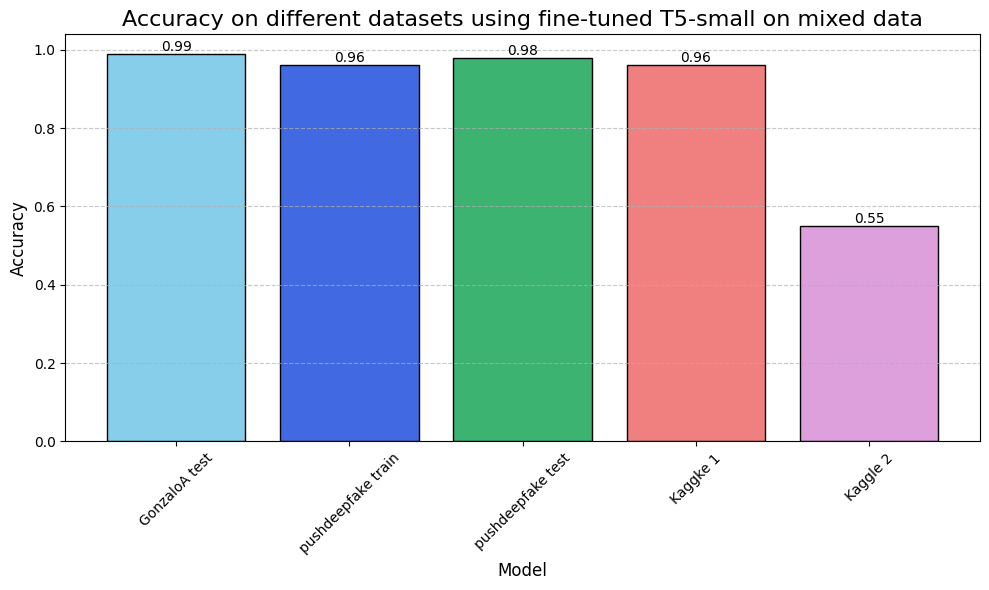

In [ ]:
import matplotlib.pyplot as plt

# Model labels
models = ["GonzaloA test","pushdeepfake train","pushdeepfake test","Kaggke 1","Kaggle 2"]

# Accuracy values
accuracies = [clean_1_test_acc, clean_2_train_acc, clean_2_test_acc, trash_1_acc, trash_2_acc]

# Create a color list to distinguish between 'summ' and non-summ models
colors = ['skyblue', 'royalblue', 'mediumseagreen', 'lightcoral', 'plum']

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor='black')

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom', ha='center')

plt.title('Accuracy on different datasets using fine-tuned T5-small on mixed data', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
new = pd.read_csv("https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/mrm8488-fake-news/fake_news.csv")

In [ ]:
new = new.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
new = new.sample(frac=1, random_state=42)
new.dropna(subset=['text'], inplace=True)
new['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


In [ ]:
new_acc = evaluate_data(new)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
        fake       1.00      0.98      0.99        50
        real       1.00      1.00      1.00        50

    accuracy                           0.99       100
   macro avg       0.67      0.66      0.66       100
weighted avg       1.00      0.99      0.99       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
